In [21]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
import matplotlib.pyplot as plt
import random
import json
from dotenv import load_dotenv
import os
from tqdm import tqdm
import time
import networkx as nx
load_dotenv() 

True

## Cycle Graph Creation

Prompt

In [22]:
from langchain.prompts import PromptTemplate

cycle_graph_generation_prompt = PromptTemplate.from_template(
    '''
    Your task is to create a dialogue graph based on a given topic. 
    The dialogue must be written in English, consist of exactly two people talking, showing user-assistant interaction. 
    The graph should be **cyclic**, meaning the **last edge should connect the last node back to the first node**, forming a loop. This transition must be logical and make sense in the context of the conversation.
    
    You have a set of nodes where the assistant (chatbot) responds 
    and a set of transitions (edges) that are triggered by user requests. 

    **NODES** must consist of utterances from the **assistant (chatbot)**, and **EDGES** must consist of utterances from the **user**.

    You have an example of a dialogue from a customer chatbot system:
    "edges": [
        {{ "source": 1, "target": 2, "utterances": ["I need to make an order", "I want to order from you"] }},
        {{ "source": 2, "target": 3, "utterances": ["I would like to purchase 'Pale Fire' and 'Anna Karenina', please", "I want to buy two books: 'Pale Fire' and 'Anna Karenina'"] }},
        {{ "source": 3, "target": 4, "utterances": ["Cash", "I'll pay in cash"] }},
        {{ "source": 4, "target": 1, "utterances": ["Start new order", "I want to start over"] }}
    ],
    "nodes": [
        {{ "id": 1, "label": "start", "is_start": true, "utterances": ["How can I help?", "Welcome! What can I do for you?"] }},
        {{ "id": 2, "label": "ask_books", "is_start": false, "utterances": ["Which books would you like to order?", "What books are you interested in?"] }},
        {{ "id": 3, "label": "ask_payment_method", "is_start": false, "utterances": ["Please select your payment method: cash or credit card.", "How would you like to pay? We accept cash or credit card."] }},
        {{ "id": 4, "label": "ask_to_redo", "is_start": false, "utterances": ["Something went wrong. Would you like to try another payment method or start a new order?", "There seems to be an issue. You can try a different payment method or begin a new order."] }}
    ]
    
    **Note:** Since the graph is cyclic, the last edge connects the last node back to the first node, and this transition should be logical.

    **Rules:**
    1) **Edge utterances** (from the user) should be logical replies to the assistant's **source utterances**, and the assistant's **target utterances** should logically follow the user's edge utterances. The transition from source to target via the edge should make sense when read left to right.

       **This is an invalid transition:**
       {{'source_utterances': ['What type of advice do you need?', 'How can I assist you today?'], 'edge_utterance': ['What assistance can you provide?', 'Tell me how you can help me?'], 'target_utterances': ["I'm here to help with anything you need.", 'Please let me know how I can assist.'], 'topic': 'General assistance dialogue between assistant and user'}}
       
    2) **Utterances in the same list should have the same meaning but different wording (synonyms).**

       **These are examples of invalid utterances:**
       - ["I'm thinking of making pasta", "I want to cook a stir-fry"]
       - ["I would like to bake a cake", "I'm interested in making a salad"]

    3) The graph must be a valid **JSON** string in the specified format, using the structure and naming conventions from the examples.

    4) Return **ONLY** the JSON string in plain text (**no code blocks**) without any additional commentary.

    5) **Ensure that the last edge logically connects the last node back to the first node.** The transition should be natural and make sense in the context of the conversation.

    6) Cycle Completion: Last nodes and edges must create a logical transition back to the start. The conversation restart should feel natural and purposeful. 
    The cycle should maintain context while allowing for a fresh start
    
    7) Grpah can have any amount of nodes and edges, experiment with it, just make it reasonable.
    **Your task is to create a dialogue graph about the following topic:** {topic}.
    '''
)


In [6]:
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel, Field
from typing import List, Optional
from langchain_core.output_parsers import JsonOutputParser

class Edge(BaseModel):
    source: int = Field(description="ID of the source node")
    target: int = Field(description="ID of the target node")
    utterances: str = Field(description="User's utterance that triggers this transition")

class Node(BaseModel):
    id: int = Field(description="Unique identifier for the node")
    label: str = Field(description="Label describing the node's purpose")
    is_start: bool = Field(description="Whether this is the starting node")
    utterances: List[str] = Field(description="Possible assistant responses at this node")

class DialogueGraph(BaseModel):
    edges: List[Edge] = Field(description="List of transitions between nodes")
    nodes: List[Node] = Field(description="List of nodes representing assistant states")


parser = JsonOutputParser(pydantic_object=DialogueGraph)


model = ChatOpenAI(model="gpt-4o", api_key=os.getenv("OPENAI_API_KEY"), base_url=os.getenv("OPENAI_BASE_URL"), temperature=0)

generate_graph_chain = cycle_graph_generation_prompt | model | parser



In [27]:
topic = "postal services at reception in the office"
graph = generate_graph_chain.invoke({"topic": topic})

In [28]:
print("=== Raw JSON View ===")
for edge in graph['edges']:
    print(f"Edge {edge['source']} → {edge['target']}:")
    print("  User utterances:")
    for utterance in edge['utterances']:
        print(f"    - {utterance}")
    print()

print("Nodes:")
for node in graph['nodes']:
    print(f"Node {node['id']} ({node['label']}):")
    print("  Assistant utterances:")
    for utterance in node['utterances']:
        print(f"    - {utterance}")
    print()

=== Raw JSON View ===
Edge 1 → 2:
  User utterances:
    - I need to send a package
    - I want to mail a parcel

Edge 2 → 3:
  User utterances:
    - It's a document
    - It's a small package

Edge 3 → 4:
  User utterances:
    - Standard delivery
    - Regular shipping

Edge 4 → 5:
  User utterances:
    - Yes, please
    - That would be great

Edge 5 → 1:
  User utterances:
    - I have another package to send
    - I need to mail something else

Nodes:
Node 1 (start):
  Assistant utterances:
    - How can I assist you with postal services today?
    - Welcome to the reception! How may I help you with your mailing needs?

Node 2 (ask_package_type):
  Assistant utterances:
    - What type of package are you sending?
    - Could you tell me what kind of parcel it is?

Node 3 (ask_delivery_option):
  Assistant utterances:
    - Which delivery option would you prefer?
    - How would you like it shipped?

Node 4 (ask_confirmation):
  Assistant utterances:
    - Would you like a tracki

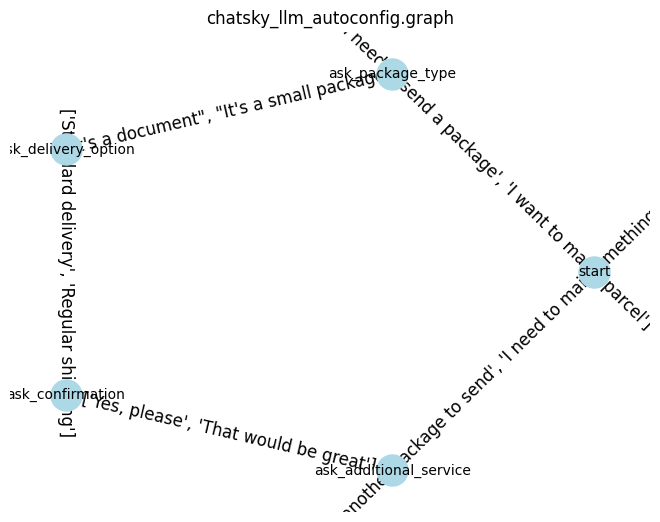

In [29]:
from chatsky_llm_autoconfig.graph import Graph
converted_graph =  Graph(graph)
converted_graph.visualise()

## Best Graph Selection

In [10]:
from langchain.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from typing import List, Tuple
import os

def is_graph_valid(graph: DialogueGraph, topic: str) -> dict:
    """
    Validates the dialog graph structure and logical transitions between nodes.

    Parameters:
        graph (dict): A dictionary containing 'nodes' and 'edges' of the graph.
        topic (str): The topic of the dialog.

    Returns:
        dict: {'isValid': bool, 'description': str}
    """
    # Create a mapping from node IDs to node data for quick access
    node_map = {node['id']: node for node in graph['nodes']}
    overall_valid = True
    descriptions = []

    for edge in graph['edges']:
        source_id = edge['source']
        target_id = edge['target']
        edge_utterances = edge['utterances']

        # Check if source and target nodes exist
        if source_id not in node_map:
            description = f"Invalid edge: source node {source_id} does not exist."
            print(description)
            overall_valid = False
            descriptions.append(description)
            continue
        if target_id not in node_map:
            description = f"Invalid edge: target node {target_id} does not exist."
            print(description)
            overall_valid = False
            descriptions.append(description)
            continue

        source_node = node_map[source_id]
        target_node = node_map[target_id]

        # Get utterances from nodes
        source_utterances = source_node.get('utterances', [])
        target_utterances = target_node.get('utterances', [])

        # Validate the transition
        isValid, description = validate_transition(source_utterances, edge_utterances, target_utterances, topic)
        if not isValid:
            overall_valid = False
            description = f"Invalid transition from {source_utterances} to {target_utterances} via edge '{edge_utterances}': {description}"
            print(description)
            descriptions.append(description)

    result = {
        'isValid': overall_valid,
        'description': ' '.join(descriptions) if descriptions else 'All transitions are valid.'
    }
    return result

prompt_template = """
You are given a dialog between assistant and a user.
source_utterances, edge_utterance, target_utterances are dialog parts and are arrays of synonymous expressions.
They sould be read left to right.

- source_utterances are assistant phrases 
- edge_utterances are user phrases
- target_utterances are assistant phrases 

TASK. Evaluate if the transition makes a logical connection when reading from Source utterances to Target utterances through Edge utterance

this is an invalid transition:
{{
    'source_utterances': [
        'Welcome to our online bookstore. How can I assist you today?',
        'Hello! Are you looking for any book recommendations?'
    ],
    'edge_utterance': [
        'Hello! Are you looking for any book recommendations?',
        'What genre of books do you prefer?'
    ],
    'target_utterances': [
        'We have a wide selection of genres. Which do you prefer?',
        'Can I help you find a specific book?'
    ],
    'topic': 'Dialog about purchasing books between assistant and customer'
}}

Provide your answer in the following JSON format:
{{"isValid": true or false, "description": "Explanation of why it's valid or invalid."}}

Dialog topic: {topic}

(source_utterances) {source_utterances} -> (edge_utterances) {edge_utterances} -> (target_utterances) {target_utterances}

Your answer:"""

prompt = PromptTemplate(
    input_variables=["source_utterances", "edge_utterances", "target_utterances", "topic"],
    template=prompt_template,
)

class TransitionValidationResult(BaseModel):
    isValid: bool = Field(description="Whether the transition is valid or not.")
    description: str = Field(description="Explanation of why it's valid or invalid.")

# Initialize the output parser
parser = PydanticOutputParser(pydantic_object=TransitionValidationResult)


# Define the validate_transition function
def validate_transition(source_utterances: List[str], edge_utterances: str, target_utterances: List[str], topic: str) -> Tuple[bool, str]:
    """
    Validates a single transition in the graph using the language model.

    Parameters:
        source_utterances (List[str]): Utterances from the source node (assistant).
        edge_utterance (str): The utterance on the edge (user).
        target_utterances (List[str]): Utterances from the target node (assistant).
        topic (str): The topic of the dialog.

    Returns:
        Tuple[bool, str]: isValid and description.
    """
    # Prepare input data for the chain
    input_data = {
        "source_utterances": source_utterances,
        "edge_utterances": edge_utterances,
        "target_utterances": target_utterances,
        "topic": topic
    }
    
    model = ChatOpenAI(model="gpt-4o-mini", api_key=os.getenv("OPENAI_API_KEY"), base_url=os.getenv("OPENAI_BASE_URL"), temperature=0)

    
    triplet_check_chain = prompt | model | parser

    
    response = triplet_check_chain.invoke(input_data)
    
    isValid = response.isValid
    description = response.description
    return isValid, description


result = is_graph_valid(graph, topic)
print(result)


{'isValid': True, 'description': 'All transitions are valid.'}


## Sampling

In [11]:
import random
import networkx as nx

def sample_dialogue(graph_obj: nx.DiGraph, start_node, end_node=None, topic=None):
    nodes = graph_obj.nodes(data=True)
    edges = graph_obj.edges(data=True)
    current_node_id = start_node
    current_node = nodes[current_node_id]
    dialogue = []
    graph = {"nodes": [], "edges": []}

    while not (current_node_id == start_node and dialogue != []) and current_node_id != end_node:
        # Add current node's utterance
        utterance = random.choice(current_node["utterances"])
        dialogue.append({"text": utterance, "participant": "assistant"})

        graph["nodes"].append({
            "id": current_node_id,
            "label": graph_obj.nodes[current_node_id]["label"],
            "theme": graph_obj.nodes[current_node_id]["theme"],
            "utterances": [utterance],
        })

        # Get possible edges from current node
        possible_edges = [edge for edge in edges if edge[0] == current_node_id]
        if not possible_edges:
            break

        # Choose next edge based on topic if specified
        if topic is not None:
            topic_edges = [edge for edge in possible_edges 
                         if graph_obj.edges[edge[0], edge[1]]["theme"] == topic]
            if not topic_edges:
                # If no edges match the topic, fall back to any available edge
                chosen_edge = random.choice(possible_edges)
            else:
                chosen_edge = random.choice(topic_edges)
        else:
            chosen_edge = random.choice(possible_edges)

        # Get edge utterance
        if isinstance(chosen_edge[2]["utterances"], list):
            edge_utterance = random.choice(chosen_edge[2]["utterances"])
        else:
            edge_utterance = chosen_edge[2]["utterances"]

        # Add user dialogue
        dialogue.append({
            "text": edge_utterance,
            "participant": "user",
            "source": chosen_edge[0],
            "target": chosen_edge[1],
        })

        # Add edge to graph
        graph["edges"].append({
            "source": chosen_edge[0],
            "target": chosen_edge[1],
            "theme": graph_obj.edges[chosen_edge[0], chosen_edge[1]]["theme"],
            "utterances": [edge_utterance],
        })

        # Move to next node
        current_node_id = chosen_edge[1]
        current_node = nodes[current_node_id]

    return dialogue, graph
d, g = sample_dialogue(converted_graph.graph, 1, topic=topic)

In [13]:
d

[{'text': 'How can I assist you with postal services today?',
  'participant': 'assistant'},
 {'text': 'I want to mail a parcel',
  'participant': 'user',
  'source': 1,
  'target': 2},
 {'text': "Could you tell me what you're mailing?",
  'participant': 'assistant'},
 {'text': "It's a small item",
  'participant': 'user',
  'source': 2,
  'target': 3},
 {'text': 'Do you prefer regular or expedited shipping?',
  'participant': 'assistant'},
 {'text': 'Regular shipping', 'participant': 'user', 'source': 3, 'target': 4},
 {'text': 'Shall I provide you with a tracking code?',
  'participant': 'assistant'},
 {'text': 'Yes, please', 'participant': 'user', 'source': 4, 'target': 5},
 {'text': 'Is there anything else you need help with?',
  'participant': 'assistant'},
 {'text': 'I have another package to send',
  'participant': 'user',
  'source': 5,
  'target': 1}]

## Dialogue Augmentation

In [19]:
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from typing import List, Dict, Any

augmentation_prompt = PromptTemplate.from_template("""
You are tasked with augmenting a dialogue by adding variations to existing utterances while maintaining the original dialogue flow and intent.

THEME: {topic}

INPUT DIALOGUE:
{dialogue}

INSTRUCTIONS:
1. For each message in the dialogue:
   - Keep the same structure (participant, source, target if present)
   - Create 2-3 variations of the 'text' field that:
     * Express the same meaning/intent
     * Use different wording and phrasing
     * Match the given theme
     * Sound natural and conversational

2. The output must be a list of dictionaries, where each dictionary has:
   - 'text': string
   - 'participant': either 'user' or 'assistant'
   - 'source' and 'target' fields (only for user messages)
   
3. Ensure all utterance variations:
   - Are appropriate for the theme
   - Maintain consistency in tone and style
   - Make sense in the conversation flow

Return ONLY a valid JSON array containing the augmented dialogue messages. Each message should be in this exact format:
For assistant messages: {{"text": "utterance text", "participant": "assistant"}}
For user messages: {{"text": "utterance text", "participant": "user", "source": number, "target": number}}

Example format:
[
    {{"text": "How may I assist you today?", "participant": "assistant"}},
    {{"text": "I need help with a package", "participant": "user", "source": 1, "target": 2}},
    {{"text": "What kind of package is it?", "participant": "assistant"}}
]
""")

class DialogueMessage(BaseModel):
    text: str
    participant: str
    source: Optional[int] = None
    target: Optional[int] = None

class DialogueSequence(BaseModel):
    result: List[DialogueMessage]

parser = JsonOutputParser(pydantic_object=DialogueSequence)

# Usage
model = ChatOpenAI(
    model="gpt-4o-mini", 
    api_key=os.getenv("OPENAI_API_KEY"), 
    base_url=os.getenv("OPENAI_BASE_URL"), 
    temperature=0.7
)

chain = augmentation_prompt | model | parser


result = chain.invoke({
    "topic": topic,
    "dialogue": d
})